## 生成高阶曲面

对于奇怪的，但是具有参数表达式的曲面，生成高阶网格

### 生成扰动环面（念珠形状曲面）的二次参数有限元曲面

Perturbed torus
\begin{equation*}
\begin{pmatrix}
(1+\cos\varphi)\cos\theta\\ (1+\cos\varphi)\sin\theta\\
\sin \varphi 
    \end{pmatrix}
    + 
       a \begin{pmatrix}
     \sin 6\theta \cos \varphi \cos \theta \\ 
     \sin 6\theta \cos \varphi \sin \theta  \\ 
     \sin 6\theta \sin \varphi
    \end{pmatrix}
\end{equation*}
在标准的环面的基础上，不同的 $\theta$ 对应的切片的圆的半径不同，是 $1+ a\sin 6\theta$

标准环面：
\begin{align*}
&\text{设大半径 }R=1,\ \text{小半径 }r=a=0.65.\\[4pt]
&\text{母线（位于 }x\text{-}z\text{ 平面）:}\quad
x(\phi)=R+r\cos\phi,\quad y(\phi)=0,\quad z(\phi)=r\sin\phi,
\quad \phi\in[\pi,3\pi].\\[6pt]
&\text{绕 }z\text{ 轴以角度 }\theta\in[0,2\pi)\text{ 旋转，得到环面参数化:}\\
&\mathbf r(\phi,\theta)=
\begin{pmatrix}
\bigl(R+r\cos\phi\bigr)\cos\theta\\
\bigl(R+r\cos\phi\bigr)\sin\theta\\
r\sin\phi
\end{pmatrix},
\qquad
(\phi,\theta)\in[\pi,3\pi]\times[0,2\pi).
\end{align*}

### 输出
* 基准曲面：无形变的环面
* 初始形变：无形变环面上的2次有限元函数

In [38]:
from ngsolve import *

In [39]:
# from netgen.csg import Pnt,SplineCurve2d,CSGeometry,Revolution,Sphere
import numpy as np
import netgen.meshing as ngm
from netgen.csg import *
from netgen.meshing import MeshingStep
from ngsolve.comp import IntegrationRuleSpaceSurface

In [40]:
from es_utils import pos_transformer, SurfacehInterp

In [41]:
from geometry import *

In [42]:
from ngsolve.webgui import Draw

In [43]:
from ngsolve import Mesh

In [44]:
from netgen.occ import SplineApproximation, Pnt, Axis, Face, Wire, Segment, Revolve, OCCGeometry, Z, X, Y
#%% Construction of Initial Curved Mesh
dim = 3
order = 2
msize = 0.1
dt = Parameter(0)

In [45]:
def GetRotFace(CurveFunc,msize,T_min=-np.pi/2,T_max=np.pi/2,axis=Z,is_close=False,n=100):
    '''
        Generate Rotational Mesh by revolving a 2d curve (CurveFunc) around an axis (axis)
        CurveFunc: function of phi, return (x(phi), 0, z(phi)) for example
        axis: axis of rotation, default z-axis: curve on x-z plane around z-axis
        is_close: whether the curve is closed (first point = last point)
        n: number of points on the curve
        T_min, T_max: parameter range of the curve
        msize: mesh size
        return: mesh 
    '''
    pnts = [CurveFunc(phi) for phi in np.linspace(T_min,T_max,n)]
    spline = SplineApproximation(pnts, tol=1e-4)
    f = Face(Wire([spline]))
    return f

In [46]:
def BaseTorus(phi): 
    a = 0.65
    z = a*np.sin(phi)
    res = Pnt(1+a*np.cos(phi), 0, z)
    return res

### Step 1: 生成低阶网格

In [47]:
f = GetRotFace(BaseTorus,0.08,T_min=np.pi,
                  T_max=3*np.pi,axis=Z,is_close=True)

In [48]:
# 在occ中设置某个点的mesh size
f.edges[0].vertices[0].maxh = 0.05

In [49]:
torus = f.Revolve(Axis((0,0,0), Z), 360)
mesh = Mesh(OCCGeometry(torus).GenerateMesh(maxh=msize,
            perfstepsend=ngm.MeshingStep.MESHSURFACE,grading=0.5))

* 可以直接加载一阶网格

In [51]:
mesh = Mesh("../../data/order_1_wave.vol")
fes = H1(mesh,order=1)
fesV = VectorH1(mesh,order=1)

Disp = GridFunction(fesV)
data = np.load("../../data/order_1_deformation_wave.npz")
Disp.vec.data = BaseVector(data["deform"].flatten("F"))
mesh.SetDeformation(Disp)

### Step 2: 在低阶网格的高次有限元空间上进行插值

In [52]:
fesir = IntegrationRuleSpaceSurface(mesh, order=2, definedon=mesh.Boundaries('.*'))
irs = fesir.GetIntegrationRules()

In [53]:
mesh.UnsetDeformation()
interp_obj = SurfacehInterp(mesh,order)
init_coords_3d = interp_obj.get_coords_quad() # 通过Interpolation

In [54]:
mesh.SetDeformation(Disp)
interp_obj = SurfacehInterp(mesh,order)
coords_3d = interp_obj.get_coords_quad() # 通过Interpolation
Disp0 = GridFunction(fesV)
get_gfu = lambda x: interp_obj.return_l2(x,deform=Disp) # 固定deform，防止曲面变化

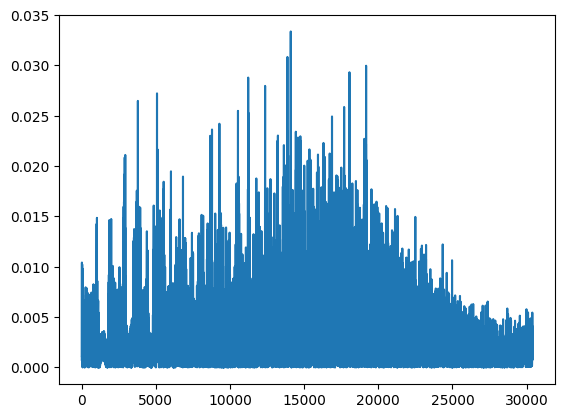

In [55]:
from geometry.param_curve import phi, psi
import sympy as sp
X_perturbed = sp.Matrix([
    (1 + 0.65*sp.cos(phi)) * sp.cos(psi),
    (1 + 0.65*sp.cos(phi)) * sp.sin(psi),
    0.65*sp.sin(phi) + 0.3*sp.sin(5*psi)
])
obj = ParamSurface(X_perturbed,num_points=400000)

phi_values, psi_values, points, tol_info = obj.proj_param(coords_3d,tol=1e-8,max_iter=10)

import matplotlib.pyplot as plt
plt.plot(np.linalg.norm(points - coords_3d, axis = 1))

In [56]:
fesV2 = VectorH1(mesh,order=order)
init_deformation = GridFunction(fesV2)

In [57]:
# 将Interpolation的位置点投影到精确曲面上
def_coords = points - init_coords_3d
deformx, deformy, deformz = map(get_gfu,[def_coords[:,0],def_coords[:,1],def_coords[:,2]])
deform_xyz = np.concatenate([deformx, deformy, deformz])
init_deformation.vec.data = BaseVector(deform_xyz)

In [58]:
mesh.SetDeformation(init_deformation)

In [60]:
Draw(Norm(Trace(specialcf.Weingarten(3))),mesh,"vv")
Draw(x,mesh,"vv")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [61]:
mesh.ngmesh.Save ("../../data/order_{}_wave.vol".format(order))

In [62]:
np.savez("../../data/order_{}_deformation_wave.npz".format(order), deform=init_deformation.vec.FV().NumPy())